In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

### Global Imports

In [2]:
import os
import datetime
import errno
import argparse

import numpy as np
import tensorflow as tf

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

Using TensorFlow backend.


### Training the Model

In [ ]:
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
dataset = 'nuclear_movie_hela0-7_same'

#direc_data = '/data/npz_data/cells/3T3/NIH/'
#dataset = 'nuclear_movie_3t3_set1_same'

training_data = np.load('{}{}.npz'.format(direc_data, dataset))

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)
in_shape = (32, 32, 1)
features = {"appearance", "distance", "neighborhood", "perimeter"}

model = siamese_model(input_shape=in_shape, features=features)

tracking_model = train_model_siamese_daughter(model=model,
                                              dataset=dataset,
                                              optimizer=optimizer,
                                              expt='transform_sync',
                                              it=0,
                                              batch_size=128,
                                              min_track_length=6,
                                              features=features,
                                              n_epoch=5,
                                              direc_save='/data/models/cells/HeLa/S3',
                                              direc_data=direc_data,
                                              lr_sched=lr_sched,
                                              rotation_range=180,
                                              flip=True,
                                              shear=0,
                                              class_weight=None)

### Data Review

In [ ]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz')
#data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_HeLa_0_same.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Contrast (or Raw) Images')
ax[1].set_title('Annotated Images')
plt.show()

In [ ]:
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['y'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

### Verifying Model Accuracy with Confusion Matrix

In [ ]:
# Import the tracking function
from deepcell.tracking import cell_tracker

# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [ ]:
import deepcell.image_generators as generators

datagen_val = generators.SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0)  # randomly flip images

val_iterator = generators.SiameseIterator(train_dict,
                                          datagen_val,
                                          occupancy_grid_size=10,
                                          crop_dim=32,
                                          min_track_length=5,
                                          features={"appearance", "distance", "neighborhood", "perimeter"})

In [ ]:
from sklearn.metrics import confusion_matrix

Y = []
Y_pred = []
for i in range(1,1001):
    if i % 100 == 0:
        print(".", end="")
    lst, y_true = next(val_iterator)
    y_true = list(map(np.argmax, y_true))
    y_pred = list(map(np.argmax, tracking_model.predict(lst)))
    Y.extend(y_true)
    Y_pred.extend(y_pred)

confusion_matrix(Y, Y_pred)

In [ ]:
sum(np.array(Y) == np.array(Y_pred)) / len(Y)

### Tracking Test

In [3]:
# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [4]:
from deepcell.model_zoo import siamese_model
from deepcell.tracking import cell_tracker

# Import the tracking model
MODEL_DIR = '/data/models'
PREFIX = 'cells/HeLa/S3'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}

# Now we need to re-instantiate the model and load weights
siamese_weights_file = '2018-11-04_nuclear_movie_hela0-7_same_[a,d,n,r]_og=20_epochs=5_normalized_0.h5'
siamese_weights_file = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

tracking_model = siamese_model(input_shape=in_shape, occupancy_grid_size=20, features=features)
tracking_model.load_weights(siamese_weights_file)

In [5]:
test_data = np.load("/data/data/cells/HeLa/S3/set0/HeLaTrackingTests/nuclear_movie_HeLa_set0_large.npz")

In [ ]:
test_data['X'][0].shape

In [12]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

#batch = 0
#trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
trial = deepcell.tracking.cell_tracker(test_data['X'][0], test_data['y'][0],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     occupancy_grid_size=20,
                     features=features)
trial._track_cells()

Tracking frame 1
New track
Division detected
appearances removed from track  106
frames in the track  [0, 1]
length of daughter track  1
daughters  [172]
new track id  173
label  107
frame being removed  1
Tracking frame 2
New track
New track
Tracking frame 3
New track
Division detected
New track
New track
New track
Tracking frame 4
New track
Division detected
Tracking frame 5
New track
Division detected
New track
Division detected
appearances removed from track  124
frames in the track  [0, 1, 2, 3, 4, 5]
length of daughter track  1
daughters  [182]
new track id  183
label  125
frame being removed  5
appearances removed from track  165
frames in the track  [0, 1, 2, 3, 4, 5]
length of daughter track  1
daughters  [181]
new track id  184
label  166
frame being removed  5
Tracking frame 6
New track
Division detected
New track
Division detected
New track
New track
appearances removed from track  2
frames in the track  [0, 1, 2, 3, 4, 5, 6]
length of daughter track  1
daughters  [185]
new

## Visualizing the Result

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='cubehelix', vmin=0, vmax=300)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=75, repeat_delay=1000)
    return HTML(ani.to_jshtml())

In [ ]:
print("track ids:", len(trial.tracks))
trial.tracks[10]['frames']
# The labels are all advanced on

# for key, track in trial.tracks.items():
#     print(key, track['daughters'])

In [ ]:
for i in range(40):
    print(i, np.unique(trial.y_tracked[i]))

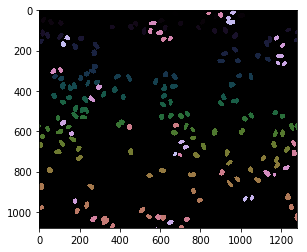

In [14]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))

In [ ]:
get_js_video(test_data['y'])
#get_js_video(train_dict['y'], batch=batch)

## Save the Raw and Tracked Output

In [15]:
channel = 0

for i in range(45):
    #name_raw = os.path.join('tracking_movies/test_true2_{:02}_.png'.format(i))
    name_tracked = os.path.join('tracking_movies/test_tracked3_{:02}_.png'.format(i))
    #plt.imsave(name_raw, test_data['y'][0, i, :, :, channel], cmap='jet')
    plt.imsave(name_tracked, trial.y_tracked[i, :, :, channel], cmap='cubehelix', vmin=0, vmax=250)


In [ ]:
print(trial.y_tracked.shape)

In [ ]:
print([trial.tracks[key]['parent'] for key in trial.tracks.keys()])
print([trial.tracks[key]['daughters'] for key in trial.tracks.keys()])
print([trial.tracks[key]['label'] for key in trial.tracks.keys()])
print([trial.tracks[key]['capped'] for key in trial.tracks.keys()])
print([key for key in trial.tracks.keys()])
print(trial.tracks[6]['frames'])
print(trial.tracks[8]['frames'])
print(trial.tracks[9]['frames'])

In [ ]:
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import time

datagen_val = SiameseDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=0,  # randomly flip images
    vertical_flip=0)  # randomly flip images

batch_size=128
min_track_length=5
# fit the model on the batches generated by datagen.flow()
test = datagen_val.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length, shuffle=False)

cm = np.zeros((3,3))
N_div = 0.
N_tot = 0.

for batch_x, batch_y in test:
    clear_output(wait=True)
    
    y_pred = tracking_model.predict(batch_x)
    
    truth = np.argmax(batch_y, axis=-1)
    pred = np.argmax(y_pred, axis=-1)
    cm_temp = confusion_matrix(truth,pred)
    if cm_temp.shape[0] == 2:
        cm[0:2,0:2] += cm_temp
    else:
        cm += confusion_matrix(truth,pred)
        
    N_div += np.sum(truth == 2)
    N_tot += truth.shape[0]
    
    print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2), N_div/N_tot)

    
# y_true = test.classes
# y_pred = tracking_model.predict_generator(test)
# print(y_pred)
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(x_test)
# print(classification_report(y_true, np.argmax(y_pred, axis=-1)))